In [1]:
from typing import List

import pytorch_lightning as pl
import torch
import wandb
import uuid
from torch import nn

from datamodule import SpritesDataModule
from simple_vae import ConvVAE
from beta_vae import ConvBetaVAE

import matplotlib.pyplot as plt
import numpy as np
import os
from rich.progress import track
from torchmetrics.image import FrechetInceptionDistance

In [3]:
SEED = 42
DEVICE = "cpu"

# Assignment 2

## Training the Model

**Run following script**
`python simple_vae.py`

Training Code in script:
```python
dm = SpritesDataModule(
    dir="dsprites-dataset",
    batch_size=512,
    val_split=0.9,
    transforms=None,
    seed=SEED,
)
dm.setup()
model = ConvVAE(
    in_channels=1,
    latent_dim=6,
    encoder_decoder_dims=[64, 128, 256, 512, 1024],
)
# Wandb logger
wandb_logger = pl.loggers.WandbLogger(project="VAE", name=f"ConvVAE_{uuid.uuid4()}")
es = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename=f"ConvVAE_{uuid.uuid4()}" + "-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)
trainer = pl.Trainer(
    accelerator="gpu",
    callbacks=[es, checkpoint_callback],
    max_epochs=50,
    logger=wandb_logger,
    fast_dev_run=False,
)
trainer.fit(model, dm)
```

## Loading the Dataloaders

In [3]:
dm = SpritesDataModule(
        dir="dsprites-dataset",
        batch_size=128,
        val_split=0.9,
        transforms=None,
        seed=SEED,
    )

dm.setup("fit")

## Loading the Trained Model

In [12]:
model_checkpoint = 'ConvVAE_86d92a1d-af98-4869-beee-5767afa6c92d-epoch=46-val_loss=11750.68.ckpt'

In [14]:
model = ConvVAE.load_from_checkpoint(f"checkpoints/{model_checkpoint}")
model.eval()

## Generate Samples and Plot them

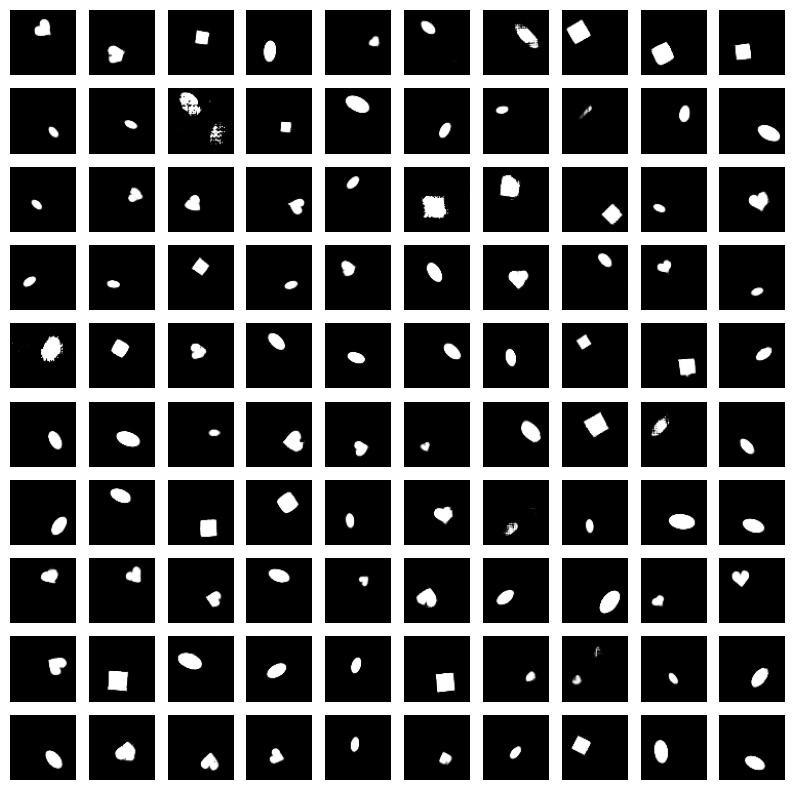

In [20]:
samples = model.sample(100)

# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


## Calculate FID

In [34]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)
fid = fid.to("cuda")

In [29]:
expand_channels = lambda x: torch.cat([x,x,x], dim=1) 

In [32]:
model = model.to("cuda")

In [35]:
reconstructions = []
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
    x, _ = batch
    x = x.to(model.device)
    reconstructions = model(x)[0].detach()
    fid.update(expand_channels(x), real=True)
    fid.update(expand_channels(reconstructions), real=False)

FID = fid.compute()
print(f"FID: {FID}")

Output()

FID: 59.99925231933594


# Assignment 3

### Helper Functions

In [13]:
heart_idx = 22921
square_idx = 950
oval_idx = 2000

def traverse_line(model, idx, n_samples, data, max_traversal):
    """Return a (size, latent_size) latent sample, corresponding to a traversal
    of a latent variable indicated by idx.
    Parameters
    ----------
    idx : int
        Index of continuous dimension to traverse. If the continuous latent
        vector is 10 dimensional and idx = 7, then the 7th dimension
        will be traversed while all others are fixed.
    n_samples : int
        Number of samples to generate.
    data : torch.Tensor or None, optional
        Data to use for computing the posterior. Shape (N, C, H, W). If
        `None` then use the mean of the prior (all zeros) for all other dimensions.
    """
    if data.size(0) > 1:
        raise ValueError("Every value should be sampled from the same posterior, but {} datapoints given.".format(data.size(0)))

    with torch.no_grad():
        post_mean, post_logvar = model.encode(data.to(model.device))
        samples = model.reparameterize(post_mean, post_logvar)
        samples = samples.cpu().repeat(n_samples, 1)
        post_mean_idx = post_mean.cpu()[0, idx]
        post_std_idx = torch.exp(post_logvar / 2).cpu()[0, idx]

    # travers from the gaussian of the posterior in case quantile
    traversals = torch.linspace(*get_traversal_range(mean=post_mean_idx,
                                                           std=post_std_idx,max_traversal=max_traversal),
                                steps=n_samples)

    for i in range(n_samples):
        samples[i, idx] = traversals[i]

    return samples

from scipy import stats

def get_traversal_range(mean=0, std=1, max_traversal=0.45):
    """Return the corresponding traversal range in absolute terms."""

    if max_traversal < 0.5:
        max_traversal = 0.5 - max_traversal  # from 0.45 to 0.05
        max_traversal = stats.norm.ppf(max_traversal, loc=mean, scale=std)  # from 0.05 to -1.645

    # symmetrical traversals
    return (-1 * max_traversal, max_traversal)

def plot_latent_traversal_grid(
    model,
    data,
    n_per_latent = 8,
    max_traversal=0.475):# corresponds to ~2 for standard normal
    n_latents = model.hparams.latent_dim
    latent_samples = [traverse_line(model, dim, n_per_latent, data=data, max_traversal=max_traversal).unsqueeze(0)
                  for dim in range(n_latents)]
    
    latent_samples = torch.cat(latent_samples, dim=0)
    decoded_traversal = model.decode(latent_samples.reshape(-1, n_latents).to(model.device))
    decoded_traversal = decoded_traversal.reshape(n_latents, n_per_latent, 64, 64)
    fig, axes = plt.subplots(n_latents, n_per_latent, figsize=(10, 10))
    for r in range(decoded_traversal.size(0)):
        for c in range(decoded_traversal.size(1)):
            axes[r][c].imshow(decoded_traversal[r,c,:,:].detach().cpu().numpy().squeeze(), cmap="gray")
            axes[r][c].axis("off")
    plt.tight_layout()
    plt.show()
    

## Training the Model

**Run following script**
`python beta_vae.py` with beta = [1, 2, 4]

Training Code in script:
```python
dm = SpritesDataModule(
    dir="dsprites-dataset",
    batch_size=512,
    val_split=0.9,
    transforms=None,
    seed=SEED,
)
dm.setup()
BETA = 4
model = ConvBetaVAE(
    in_channels=1,
    latent_dim=6,
    encoder_decoder_dims=[64, 128, 256, 512, 1024],
    beta=BETA
)
# Wandb logger
wandb_logger = pl.loggers.WandbLogger(project="VAE", name=f"ConvBeta_{BETA}_VAE_{uuid.uuid4()}")
es = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename=f"ConvBeta_{BETA}_VAE_{uuid.uuid4()}" + "-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)
trainer = pl.Trainer(
    accelerator="gpu",
    callbacks=[es, checkpoint_callback],
    max_epochs=50,
    logger=wandb_logger,
    fast_dev_run=False,
)
trainer.fit(model, dm)
```

## Loading the Dataloaders

In [4]:
dm = SpritesDataModule(
        dir="dsprites-dataset",
        batch_size=128,
        val_split=0.9,
        transforms=None,
        seed=SEED,
    )

dm.setup("fit")

## $\beta$-VAE:  $\beta = 1$

### Loading the Trained Model

In [4]:
!ls checkpoints/

'ConvBeta_1_VAE_4bc61f1c-bfe9-495b-a4eb-822760da7620-epoch=21-val_loss=788.14.ckpt'
'ConvBeta_2_VAE_93a8d064-404c-4626-bf00-34174779a816-epoch=22-val_loss=1025.52.ckpt'
'ConvBeta_4_VAE_824d958a-2c17-47e5-8d37-6d6b5b27e5e2-epoch=42-val_loss=1535.92.ckpt'
'ConvVAE_116c521f-6b37-43a6-b409-cb69e0eaf875-epoch=40-val_loss=2854.24.ckpt'
'ConvVAE_68ac55b0-7b6e-4dee-adf8-4c90208ead16-epoch=45-val_loss=2940.56.ckpt'
'ConvVAE_86d92a1d-af98-4869-beee-5767afa6c92d-epoch=46-val_loss=11750.68.ckpt'
'ConvVAE_c9e25e0e-9a1a-4800-9da6-e159a66244aa-epoch=49-val_loss=3758.52.ckpt'


In [5]:
model_checkpoint = 'ConvBeta_1_VAE_4bc61f1c-bfe9-495b-a4eb-822760da7620-epoch=21-val_loss=788.14.ckpt'

In [6]:
model = ConvBetaVAE.load_from_checkpoint(f"checkpoints/{model_checkpoint}")
model.eval()
model = model.to(DEVICE)

### Generate Samples and Plot them

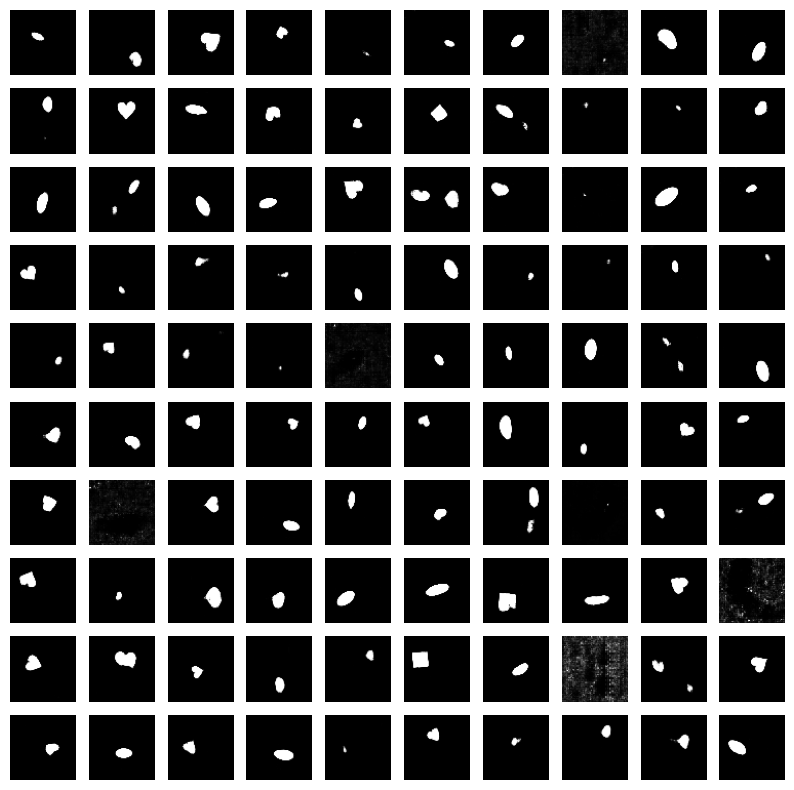

In [13]:
samples = model.sample(100)

# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


### Calculate FID

In [19]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)
fid = fid.to("cuda")

In [20]:
expand_channels = lambda x: torch.cat([x,x,x], dim=1) 

In [21]:
reconstructions = []
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
    x, _ = batch
    x = x.to(model.device)
    reconstructions = model(x)[0].detach()
    fid.update(expand_channels(x), real=True)
    fid.update(expand_channels(reconstructions), real=False)

FID = fid.compute()
print(f"FID: {FID}")

Output()

FID: 34.28084945678711


### Plot Latent Traversals

#### Square Sample

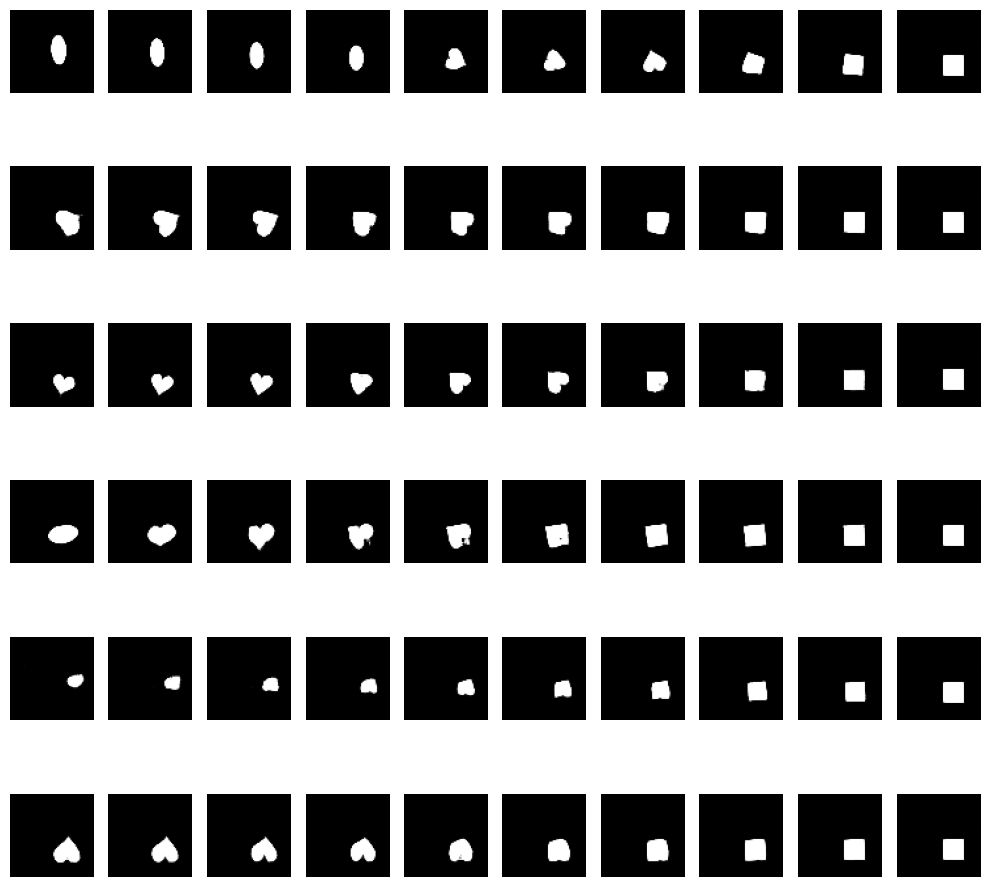

In [94]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[square_idx][0]).unsqueeze(1), 
    n_per_latent=10) 

#### Heart Sample

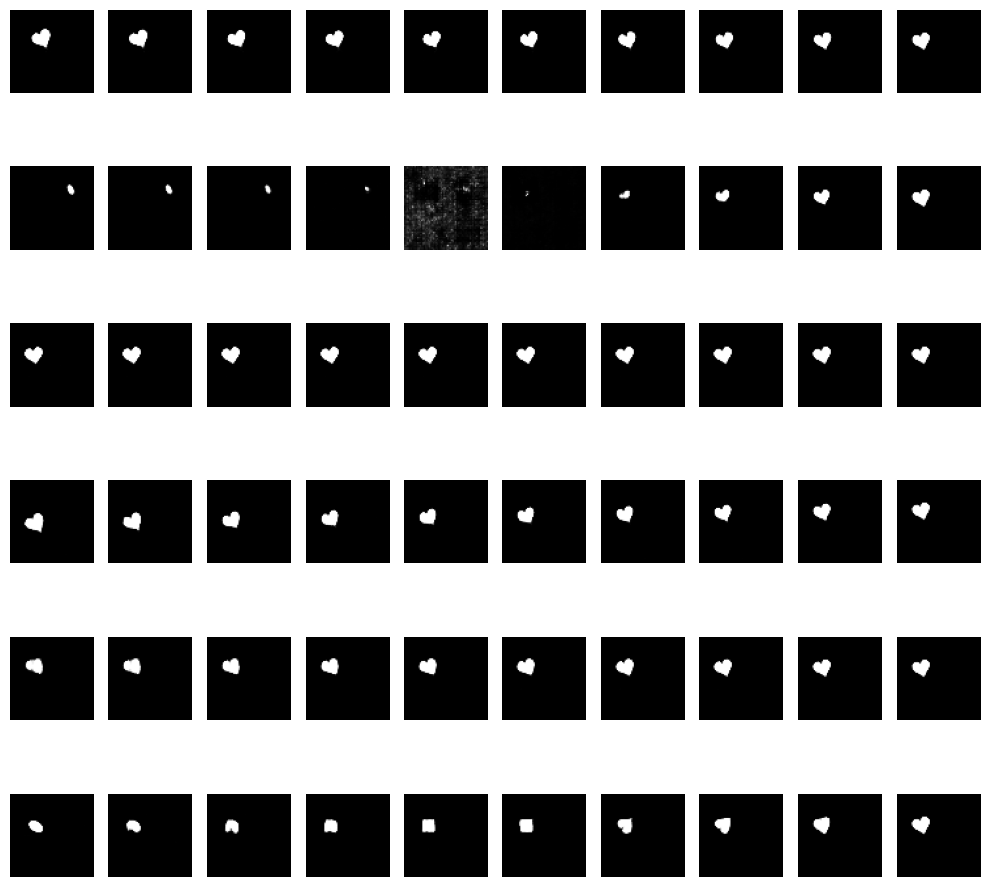

In [95]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[heart_idx][0]).unsqueeze(1), 
    n_per_latent=10) 

#### Oval Sample

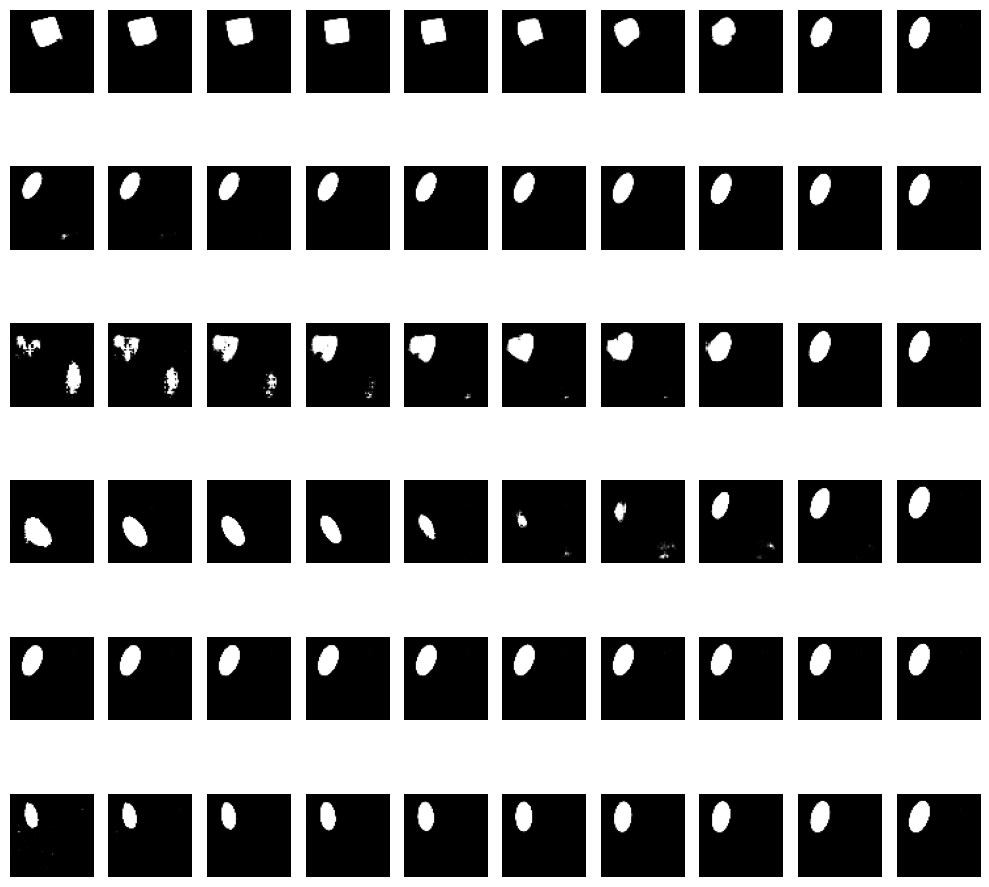

In [96]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[oval_idx][0]).unsqueeze(1), 
    n_per_latent=10) 

## $\beta$-VAE:  $\beta = 2$

### Loading the Trained Model

In [4]:
!ls checkpoints/

'ConvBeta_1_VAE_4bc61f1c-bfe9-495b-a4eb-822760da7620-epoch=21-val_loss=788.14.ckpt'
'ConvBeta_2_VAE_93a8d064-404c-4626-bf00-34174779a816-epoch=22-val_loss=1025.52.ckpt'
'ConvBeta_4_VAE_824d958a-2c17-47e5-8d37-6d6b5b27e5e2-epoch=42-val_loss=1535.92.ckpt'
'ConvVAE_116c521f-6b37-43a6-b409-cb69e0eaf875-epoch=40-val_loss=2854.24.ckpt'
'ConvVAE_68ac55b0-7b6e-4dee-adf8-4c90208ead16-epoch=45-val_loss=2940.56.ckpt'
'ConvVAE_86d92a1d-af98-4869-beee-5767afa6c92d-epoch=46-val_loss=11750.68.ckpt'
'ConvVAE_c9e25e0e-9a1a-4800-9da6-e159a66244aa-epoch=49-val_loss=3758.52.ckpt'


In [7]:
model_checkpoint = 'ConvBeta_2_VAE_93a8d064-404c-4626-bf00-34174779a816-epoch=22-val_loss=1025.52.ckpt'

In [8]:
model = ConvBetaVAE.load_from_checkpoint(f"checkpoints/{model_checkpoint}")
model.eval()
model = model.to(DEVICE)

### Generate Samples and Plot them

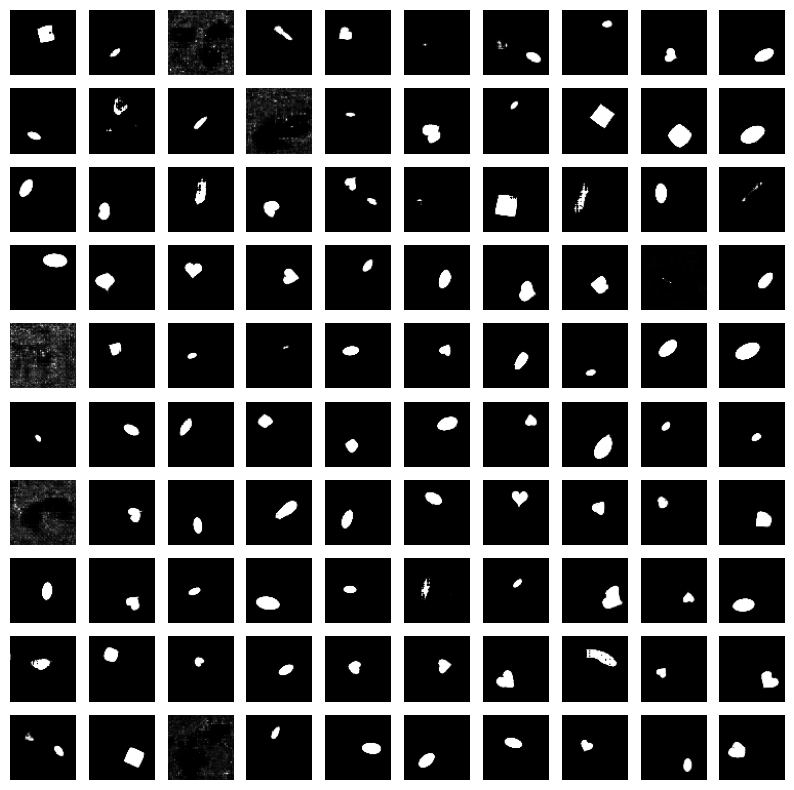

In [9]:
samples = model.sample(100)

# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


### Calculate FID

In [19]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)
fid = fid.to("cuda")

In [20]:
expand_channels = lambda x: torch.cat([x,x,x], dim=1) 

In [21]:
reconstructions = []
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
    x, _ = batch
    x = x.to(model.device)
    reconstructions = model(x)[0].detach()
    fid.update(expand_channels(x), real=True)
    fid.update(expand_channels(reconstructions), real=False)

FID = fid.compute()
print(f"FID: {FID}")

Output()

FID: 34.28084945678711


### Plot Latent Traversals

#### Square Sample

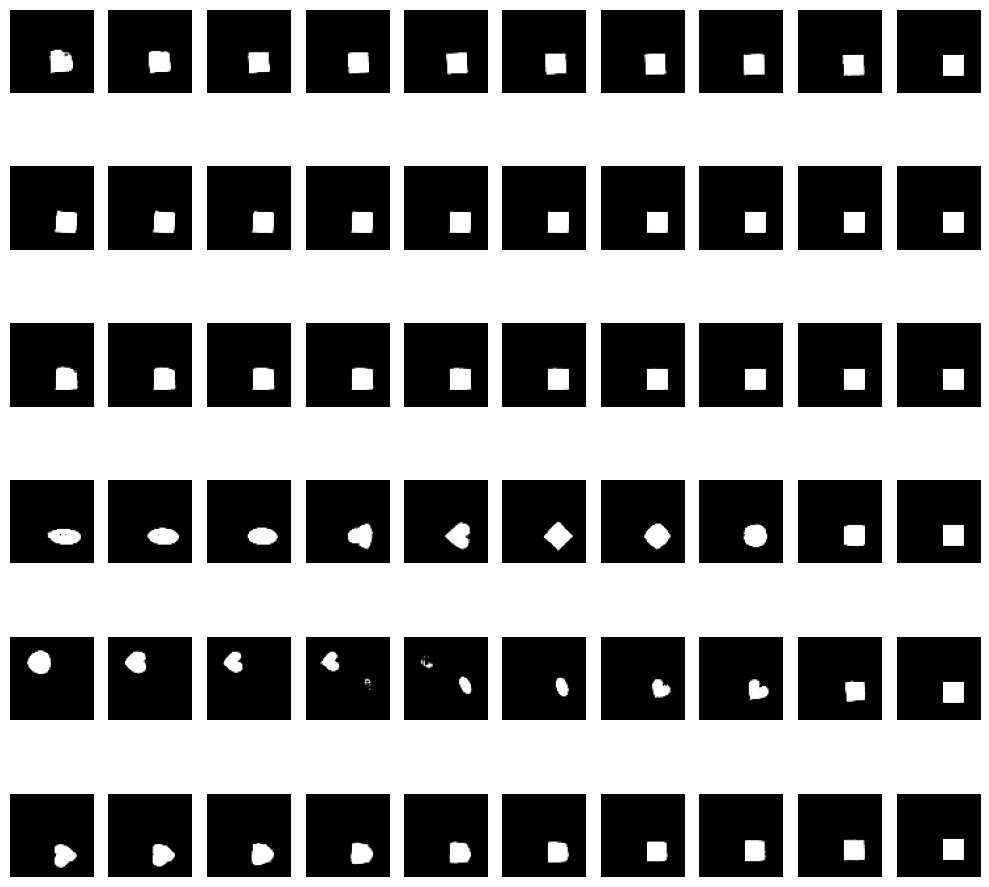

In [14]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[square_idx][0]).unsqueeze(1), 
    n_per_latent=10)

#### Heart Sample

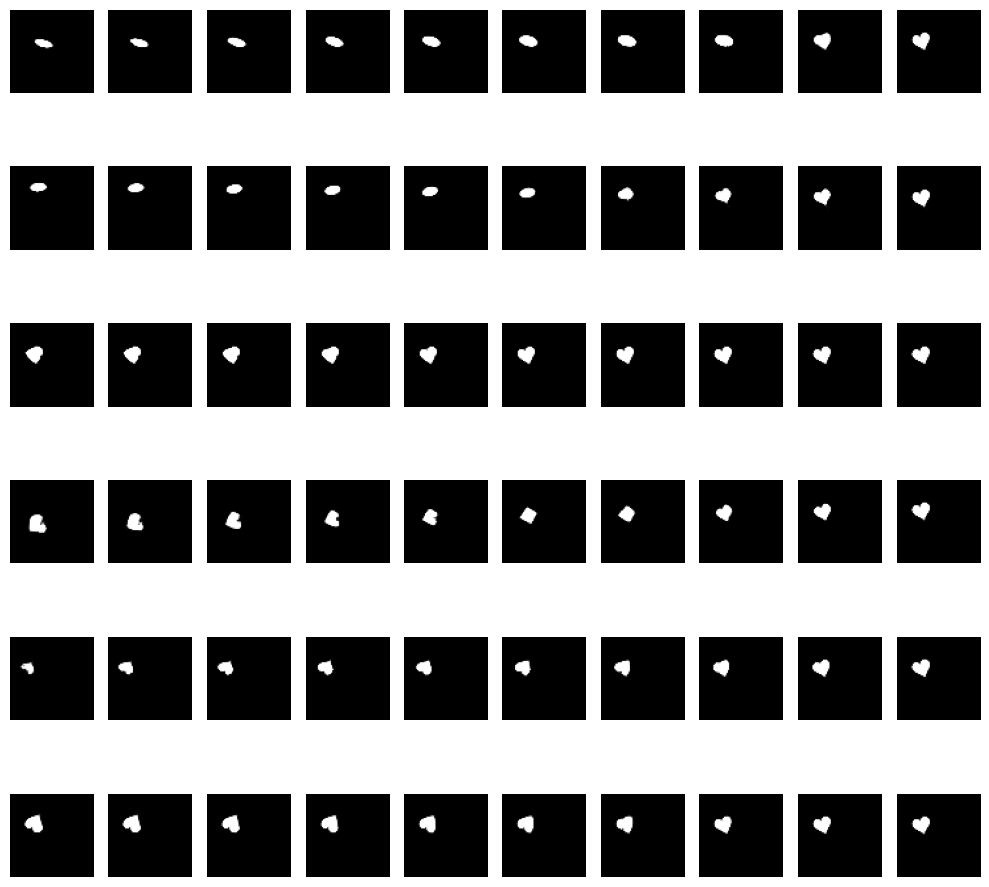

In [15]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[heart_idx][0]).unsqueeze(1), 
    n_per_latent=10) 

#### Oval Sample

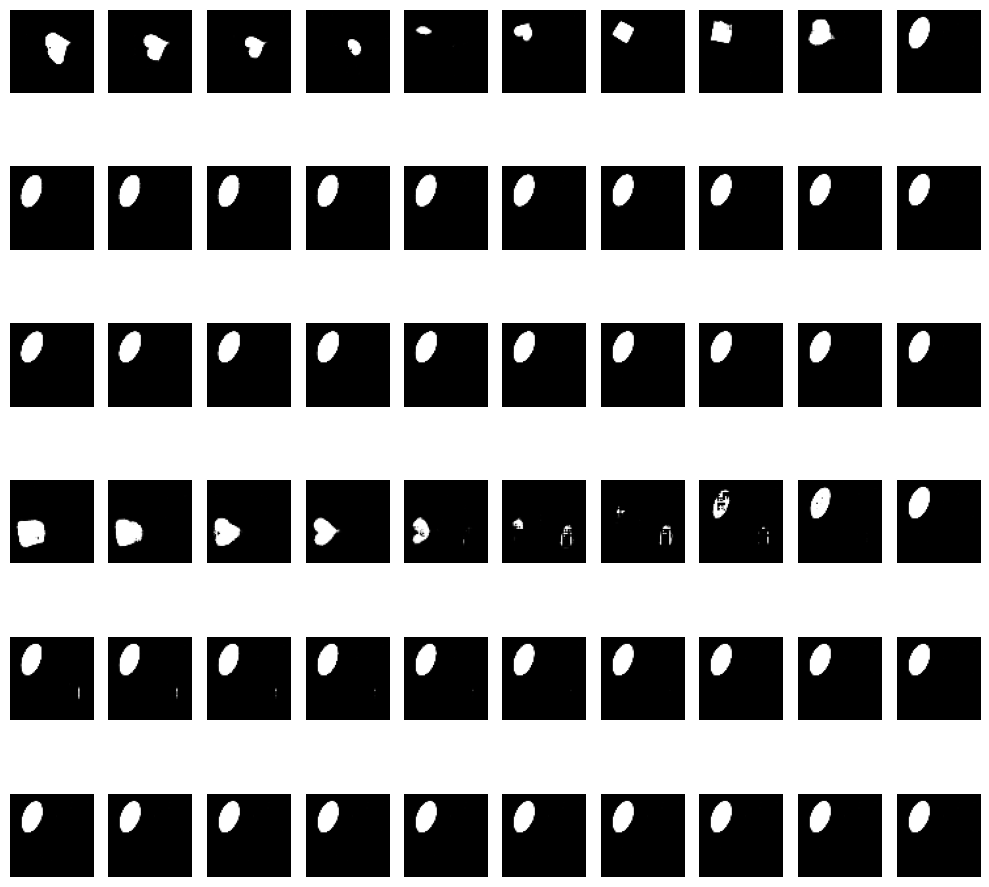

In [16]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[oval_idx][0]).unsqueeze(1), 
    n_per_latent=10) 

## $\beta$-VAE:  $\beta = 4$

### Loading the Trained Model

In [17]:
model_checkpoint = 'ConvBeta_4_VAE_824d958a-2c17-47e5-8d37-6d6b5b27e5e2-epoch=42-val_loss=1535.92.ckpt'

In [18]:
model = ConvBetaVAE.load_from_checkpoint(f"checkpoints/{model_checkpoint}")
model.eval()
model = model.to(DEVICE)

### Generate Samples and Plot them

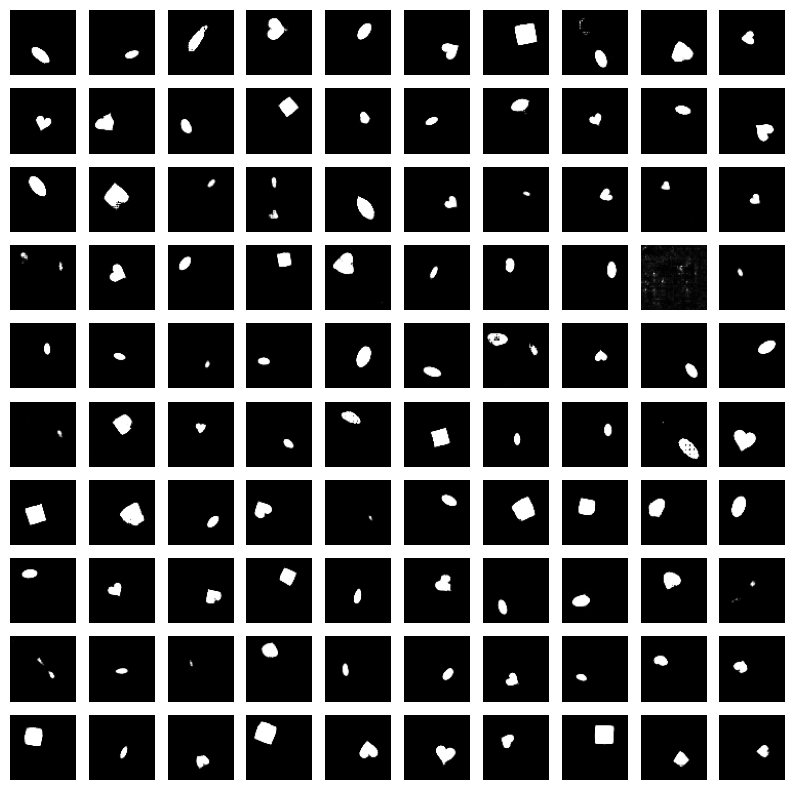

In [19]:
samples = model.sample(100)

# Plot 100 random samples of the generated images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].detach().cpu().numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


### Calculate FID

In [23]:
fid = FrechetInceptionDistance(reset_real_features=False, normalize=True)
fid = fid.to(DEVICE)

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [24]:
expand_channels = lambda x: torch.cat([x,x,x], dim=1) 

In [25]:
reconstructions = []
for batch in track(dm.val_dataloader(), total=len(dm.val_dataloader()), description=f"Generating reconstructions for {model_checkpoint}"):
    x, _ = batch
    x = x.to(model.device)
    reconstructions = model(x)[0].detach()
    fid.update(expand_channels(x), real=True)
    fid.update(expand_channels(reconstructions), real=False)

FID = fid.compute()
print(f"FID: {FID}")

Output()


KeyboardInterrupt



### Plot Latent Traversals

#### Square Sample

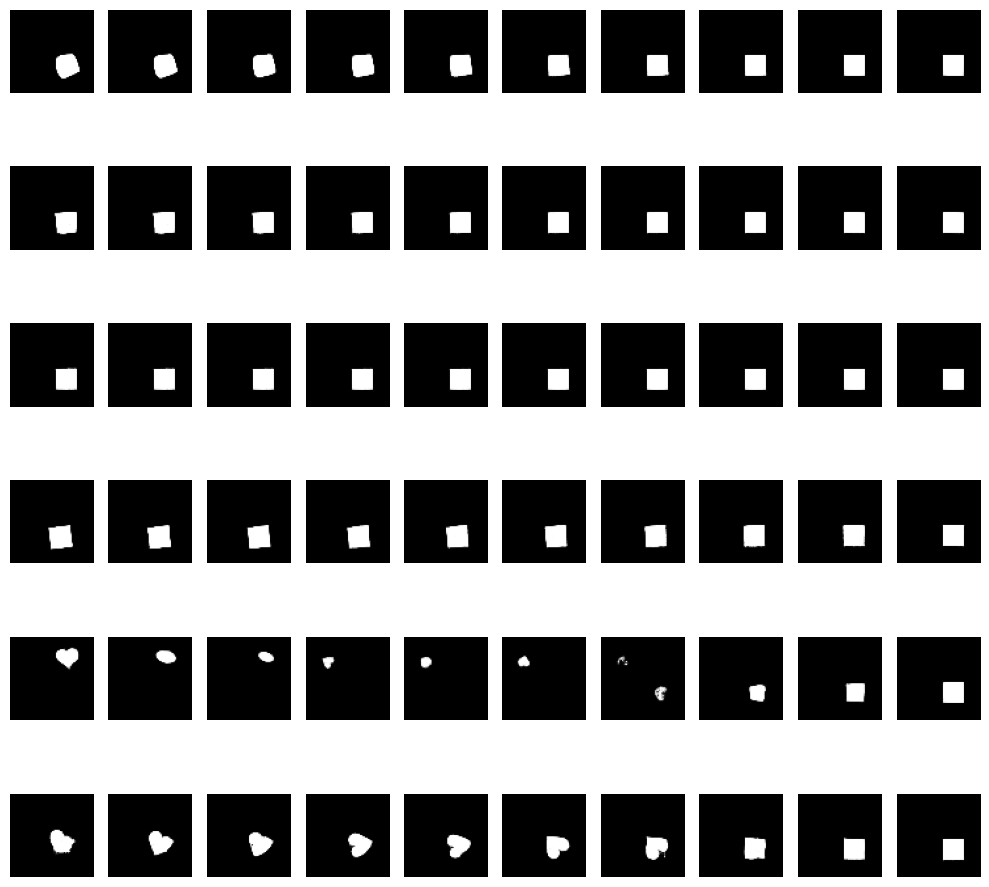

In [20]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[square_idx][0]).unsqueeze(1), 
    n_per_latent=10)

#### Heart Sample

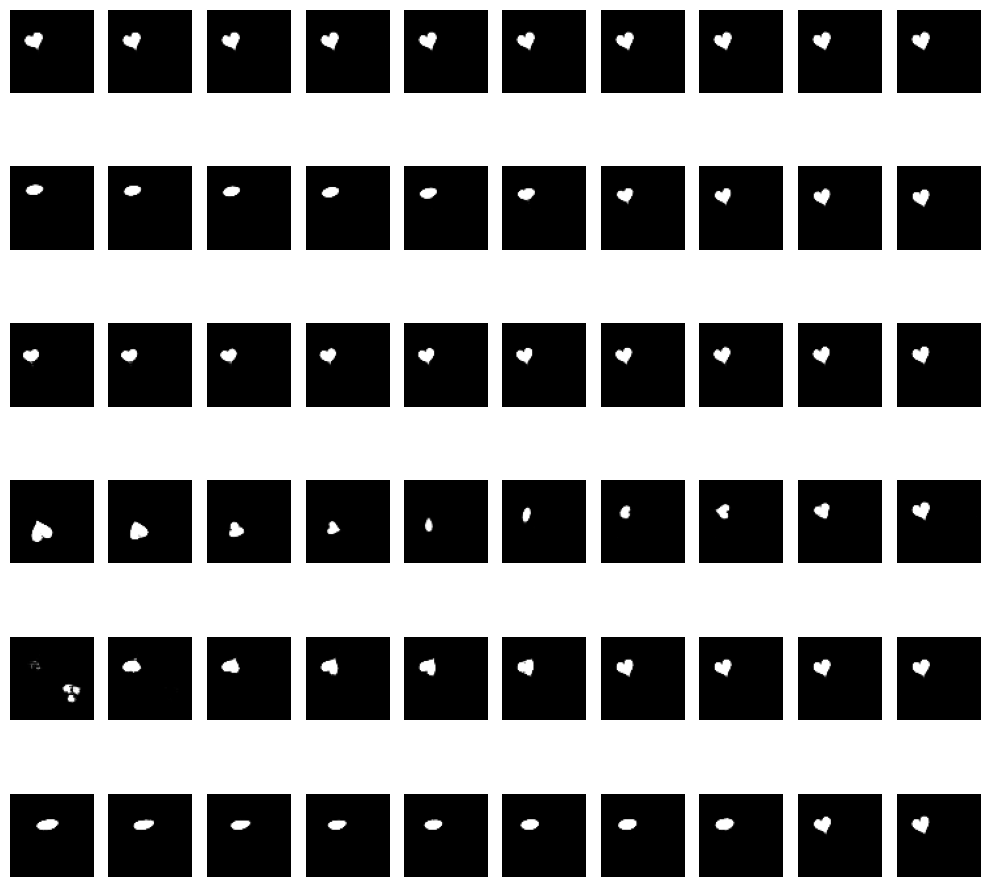

In [21]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[heart_idx][0]).unsqueeze(1), 
    n_per_latent=10) 

#### Oval Sample

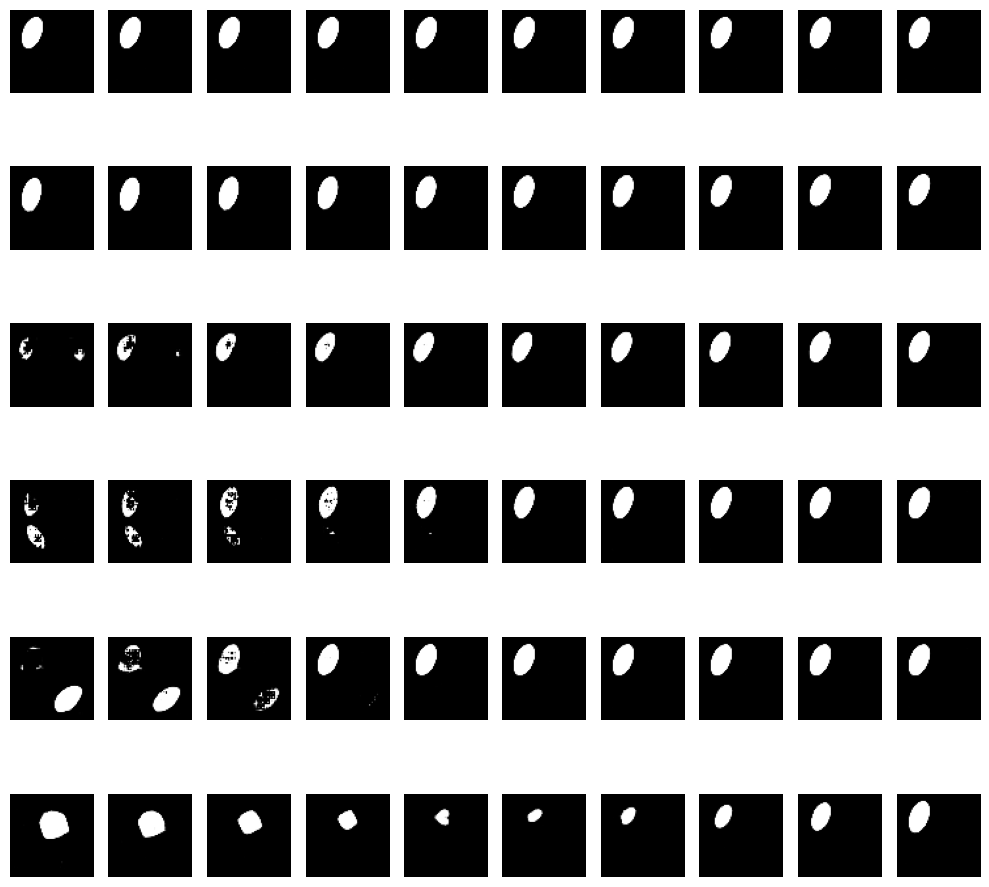

In [22]:
plot_latent_traversal_grid(
    model, 
    torch.from_numpy(dm.val_dataset[oval_idx][0]).unsqueeze(1), 
    n_per_latent=10) 